## Detect fake profiles in online social networks using Support Vector Machine

In [42]:
!pip install sklearn

You are using pip version 9.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [43]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [44]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import gender_guesser.detector as gender
# from sklearn.preprocessing import Imputer
# from sklearn import cross_validation
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline 

###### function for reading dataset from csv files

In [45]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("users.csv")
    fake_users = pd.read_csv("fusers.csv")
    print(len(genuine_users))
    print(len(fake_users))
    print(len(genuine_users)+len(fake_users))
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y
    

In [46]:
print ("reading datasets.....\n")
# import input_data
x,y=read_datasets()

reading datasets.....

1481
1337
2818


In [47]:
print(len(x),len(y))

2818 2818


In [48]:
print(x.columns)
print("\n")
print("length of columns: ",len(x.columns))


Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'created_at',
       'url', 'lang', 'time_zone', 'location', 'default_profile',
       'default_profile_image', 'geo_enabled', 'profile_image_url',
       'profile_banner_url', 'profile_use_background_image',
       'profile_background_image_url_https', 'profile_text_color',
       'profile_image_url_https', 'profile_sidebar_border_color',
       'profile_background_tile', 'profile_sidebar_fill_color',
       'profile_background_image_url', 'profile_background_color',
       'profile_link_color', 'utc_offset', 'protected', 'verified',
       'description', 'updated', 'dataset'],
      dtype='object')


length of columns:  34


In [49]:
# checking nulls
x.isnull().sum()

id                                       0
name                                     0
screen_name                              0
statuses_count                           0
followers_count                          0
friends_count                            0
favourites_count                         0
listed_count                             0
created_at                               0
url                                   2355
lang                                     0
time_zone                             1749
location                               547
default_profile                       1090
default_profile_image                 2810
geo_enabled                           2097
profile_image_url                        0
profile_banner_url                    1831
profile_use_background_image            58
profile_background_image_url_https       0
profile_text_color                       0
profile_image_url_https                  0
profile_sidebar_border_color             0
profile_bac

###### function for predicting sex using name of person

In [50]:
def predict_sex(name):
    name=str(name)
    sex_predictor = gender.Detector( case_sensitive=False)
    first_name= name.split(' ')[0]
    sex= sex_predictor.get_gender(first_name)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex_dict[sex]
    return sex_code

###### function for feature engineering

In [51]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    print(lang_list)
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int) #label encoding (manually u wrote the code)   
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

In [52]:
print ("extracting featues.....\n")
x=extract_features(x)
print (x.columns)
print (x.describe())

extracting featues.....

[(0, 'de'), (1, 'en'), (2, 'es'), (3, 'fr'), (4, 'gl'), (5, 'it'), (6, 'nl'), (7, 'tr')]
Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count  sex_code    lang_code  
count   2818.

In [53]:
x

,statuses_count,followers_count,friends_count,favourites_count,listed_count,sex_code,lang_code
0,20370,5470,2385,145,52,0,5
1,3131,506,381,9,40,0,1
2,4024,264,87,323,16,0,1
3,40586,640,622,1118,32,0,1
4,2016,62,64,13,0,0,5
...,...,...,...,...,...,...,...
1332,1,0,17,0,0,0,1
1333,0,1,17,0,0,0,1
1334,2,0,15,0,0,0,1
1335,2,0,16,0,0,0,1


In [54]:
print(len(x.columns))
print(x.isnull().sum())
print(len(x))

7
statuses_count      0
followers_count     0
friends_count       0
favourites_count    0
listed_count        0
sex_code            0
lang_code           0
dtype: int64
2818


###### function for ploting learning curve

In [55]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

###### function for plotting confusion matrix

In [56]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###### function for plotting ROC curve

In [57]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)
    
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

###### Function for training data using Support Vector Machine

In [58]:
def train(X_train,y_train,X_test):
    # Scaling features
    X_train=preprocessing.scale(X_train)
    X_test=preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    cvk = StratifiedKFold(n_splits=5)
    classifier = SVC()
    clf = GridSearchCV(classifier,param_grid=param,cv=cvk)
    clf.fit(X_train,y_train)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train,y_train)
    # Estimate score
    scores = cross_val_score(clf.best_estimator_, X_train,y_train, cv=5)
    print (scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %clf.best_estimator_.gamma
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test,y_pred

In [59]:
print ("spliting datasets in train and test dataset...\n")
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

spliting datasets in train and test dataset...



training datasets.......

The best classifier is:  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[0.92239468 0.92904656 0.93569845 0.9556541  0.94444444]
Estimated score: 0.93745 (+/- 0.00583)


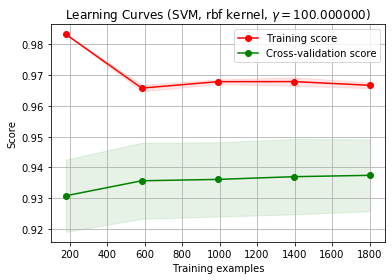

In [60]:
print ("training datasets.......\n")
from sklearn.model_selection import cross_val_score
y_test,y_pred = train(X_train,y_train,X_test)

In [61]:
print ('Classification Accuracy on Test dataset: ' ,accuracy_score(y_test, y_pred))
results=accuracy_score(y_test, y_pred)

Classification Accuracy on Test dataset:  0.900709219858156


Confusion matrix, without normalization
[[265   3]
 [ 53 243]]


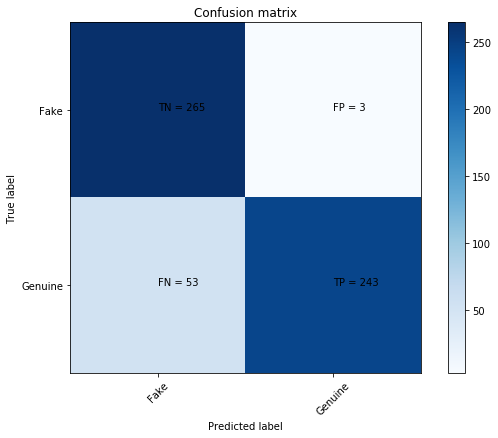

In [62]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)


Normalized confusion matrix
[[0.98880597 0.01119403]
 [0.17905405 0.82094595]]


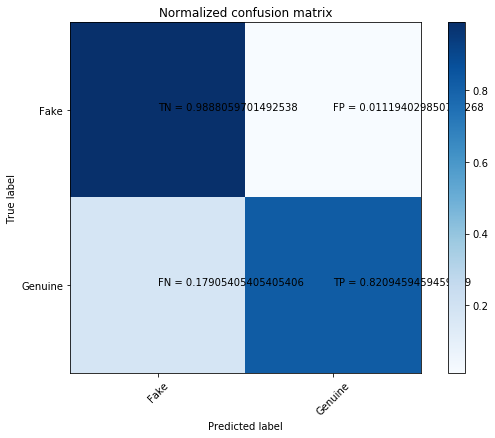

In [63]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [64]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.83      0.99      0.90       268
     Genuine       0.99      0.82      0.90       296

    accuracy                           0.90       564
   macro avg       0.91      0.90      0.90       564
weighted avg       0.91      0.90      0.90       564



False Positive rate:  [0.         0.01119403 1.        ]
True Positive rate:  [0.         0.82094595 1.        ]


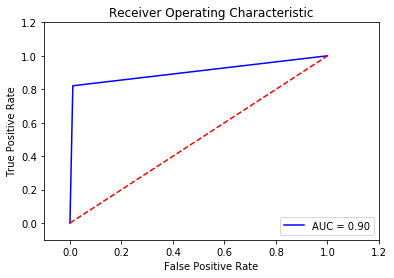

In [65]:
plot_roc_curve(y_test, y_pred)

Decision tree

In [66]:
def train1(X_train,y_train,X_test):
    # Scaling features
    X_train1=preprocessing.scale(X_train1)
    X_test1=preprocessing.scale(X_test1)

    Max_depths = 10.0 ** np.arange(-2,3,.5)
    Min_samples_splits = 10.0 ** np.arange(-2,3,.5)
    param = [{'max_depth': Max_depths, 'min_samples_split': Min_samples_splits}]
    cvk1 = StratifiedKFold(n_splits=5)
    classifier = DecisionTreeClassifier()
    clf = GridSearchCV(classifier,param_grid=param,cv=cvk1)
    clf.fit(X_train1,y_train1)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train1,y_train1)
    # Estimate score
    scores = cross_val_score(clf.best_estimator_, X_train1,y_train1, cv=5)
    print (scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (DT, max_depth, $\Min_samples_splits=%.6f$)' %clf.best_estimator_.Max_depths
    plot_learning_curve(clf.best_estimator_, title, X_train1, y_train1, cv=5)
    plt.show()
    # Predict class

In [67]:
print ("spliting datasets in train and test dataset...\n")
X_train1,X_test1,y_train1,y_test1 = train_test_split(x, y, test_size=0.20, random_state=44)

spliting datasets in train and test dataset...



In [ ]:
print ("training datasets.......\n")
from sklearn.model_selection import cross_val_score
y_test1,y_pred1 = train(X_train1,y_train1,X_test1)

training datasets.......



In [35]:
print ('Classification Accuracy on Test dataset: ' ,accuracy_score(y_test1, y_pred1))
results=accuracy_score(y_test1, y_pred1)

Classification Accuracy on Test dataset:  0.900709219858156


Confusion matrix, without normalization
[[265   3]
 [ 53 243]]


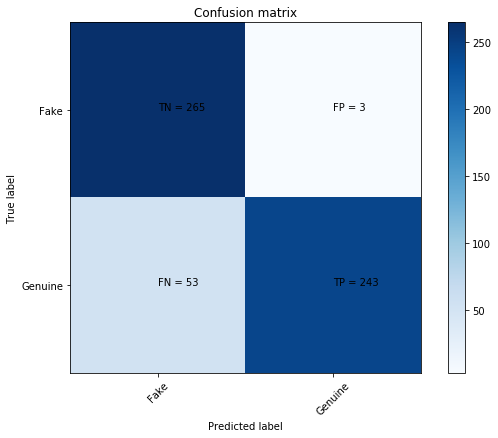

In [36]:
cm1=confusion_matrix(y_test1, y_pred1)
print('Confusion matrix, without normalization')
print(cm1)
plot_confusion_matrix(cm1)
